In [1]:
import os

os.chdir("..")

In [2]:
# Use GPU
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import random

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# Other
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from skmultilearn.model_selection import IterativeStratification
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# Transformers
import torch
import transformers 
from transformers import LongformerModel, LongformerTokenizerFast

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

## 1. Load and transform data

In [6]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [7]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [8]:
# Split into 70% training, 15% validation, and 15% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_clean'], Y, test_size=0.3)
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_test, Y_test, test_size=0.5)

## 2. Compute embeddings with pre-trained Longformer model

In [9]:
# Use GPU
# torch.cuda.empty_cache()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [10]:
# Load model and tokenizer
model = LongformerModel.from_pretrained('allenai/longformer-base-4096').to(device)
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Inference (use GPU)

# Training data

input_data = list(X_train)
outputs_train = np.zeros((len(input_data), 768))
i = 0
for sentence in tqdm(input_data):
    # Tokenize 
    tokenized_sentence = tokenizer(sentence, max_length=4096,
                                truncation=True, padding=True,
                                return_tensors="pt")
    # Add global attention mask on <s> token (equivalent to [CLS])
    global_attention_mask = torch.zeros_like(tokenized_sentence['input_ids'])
    global_attention_mask[:, 0] = 1
    tokenized_sentence["global_attention_mask"] = global_attention_mask
    with torch.no_grad():
        # Compute embeddings for batch
        last_hidden_states = model(**tokenized_sentence.to(device))
    # Store [CLS] tokens
    outputs_train[i:i+1] = last_hidden_states[0][:,0,:].cpu().numpy()
    i += 1

# Test data
input_data = list(X_test)
outputs_test = np.zeros((len(input_data), 768))
i = 0
for sentence in tqdm(input_data):
    # Tokenize 
    tokenized_sentence = tokenizer(sentence, max_length=4096,
                                truncation=True, padding=True,
                                return_tensors="pt")
    # Add global attention mask on <s> token (equivalent to [CLS])
    global_attention_mask = torch.zeros_like(tokenized_sentence['input_ids'])
    global_attention_mask[:, 0] = 1
    tokenized_sentence["global_attention_mask"] = global_attention_mask
    with torch.no_grad():
        # Compute embeddings for batch
        last_hidden_states = model(**tokenized_sentence.to(device))
    # Store [CLS] tokens
    outputs_test[i:i+1] = last_hidden_states[0][:,0,:].cpu().numpy()
    i += 1

  0%|          | 0/5485 [00:00<?, ?it/s]

  0%|          | 0/1308 [00:00<?, ?it/s]

## 3. Classification with balanced weights

### 3.1. Logistic Regression

In [13]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced", solver='liblinear')))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:   17.5s remaining:   26.3s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   33.1s remaining:    8.3s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   39.5s finished


Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.6797419993146004


              precision    recall  f1-score   support

           0       0.30      0.65      0.42       156
           1       0.89      0.73      0.80      1077
           2       0.85      0.71      0.78      1041
           3       0.86      0.68      0.76       981
           4       0.86      0.65      0.74      1011
           5       0.82      0.62      0.70       958
           6       0.83      0.65      0.73       899
           7       0.29      0.63      0.40       153
           8       0.91      0.68      0.78      1116
           9       0.79      0.64      0.70       828
          10       0.57      0.63      0.60       472
          11       0.83      0.65      0.73       930
          12       0.29      0.63      0.40       153

   micro avg       0.77      0.67      0.71      9775
   macro avg       0.70      0.66      0.66      9775
weighted avg       0.81      0.67      0.73      9775
 samples avg       0.74      0.64      0.64      9775



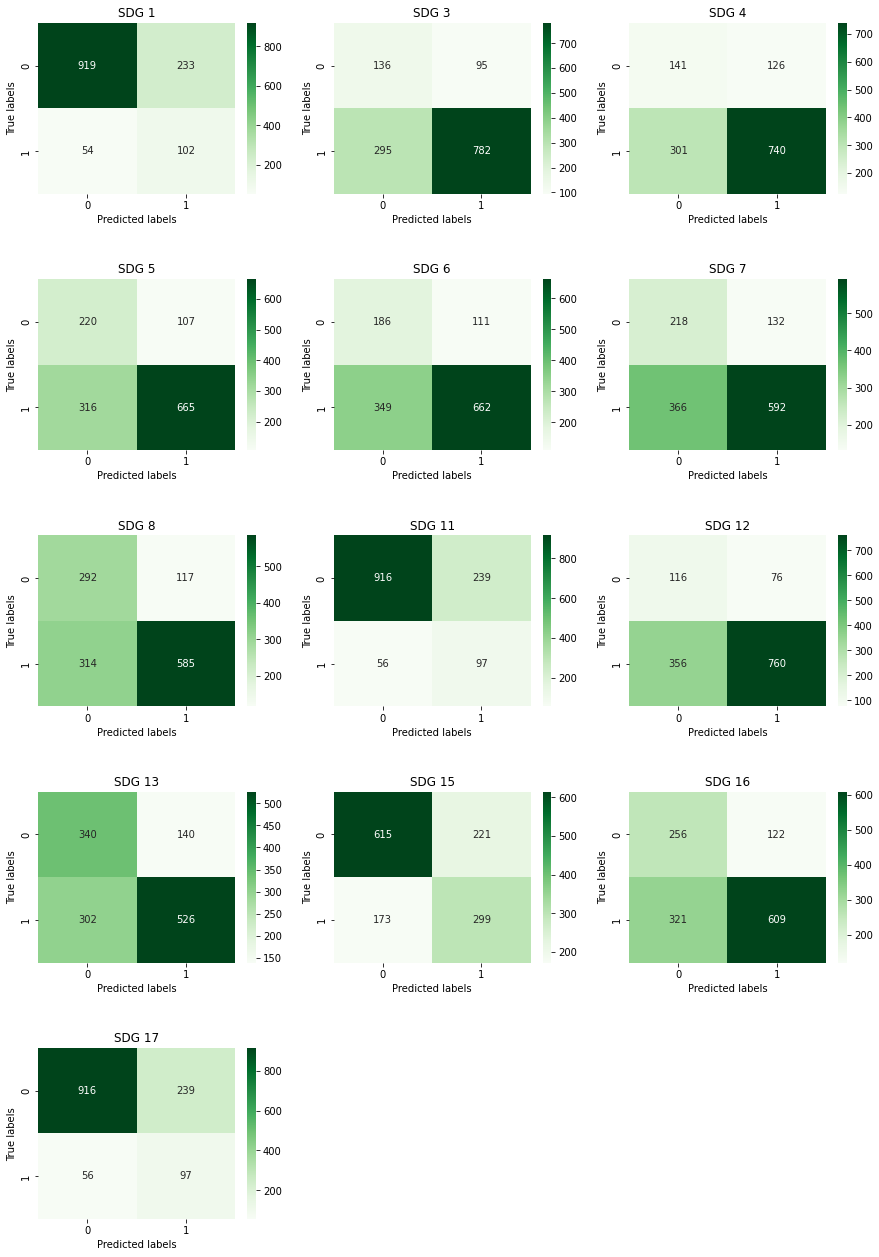

In [14]:
evaluation(grid_lr, outputs_test, Y_test)

### 3.2. Linear SVM

In [15]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_svm.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.676, total=   5.5s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.672, total=  21.4s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.666, total= 2.7min
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.663, total=   5.4s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator

[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:  2.7min remaining:  4.1min


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:  5.9min remaining:  1.5min
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:  6.0min finished


[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.685, total=  12.1s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.679, total= 2.7min
Best Parameters: {'clf__estimator__C': 0.1}
Mean cross-validated F1-score of the best estimator: 0.6702801782472966


[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.679, total=  11.6s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.669, total=  20.8s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.669, total= 2.4min
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.662, total= 2.4min
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.680, total=  11.4s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.668, total=  21.8s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.669, total= 2.4min
[CV] c

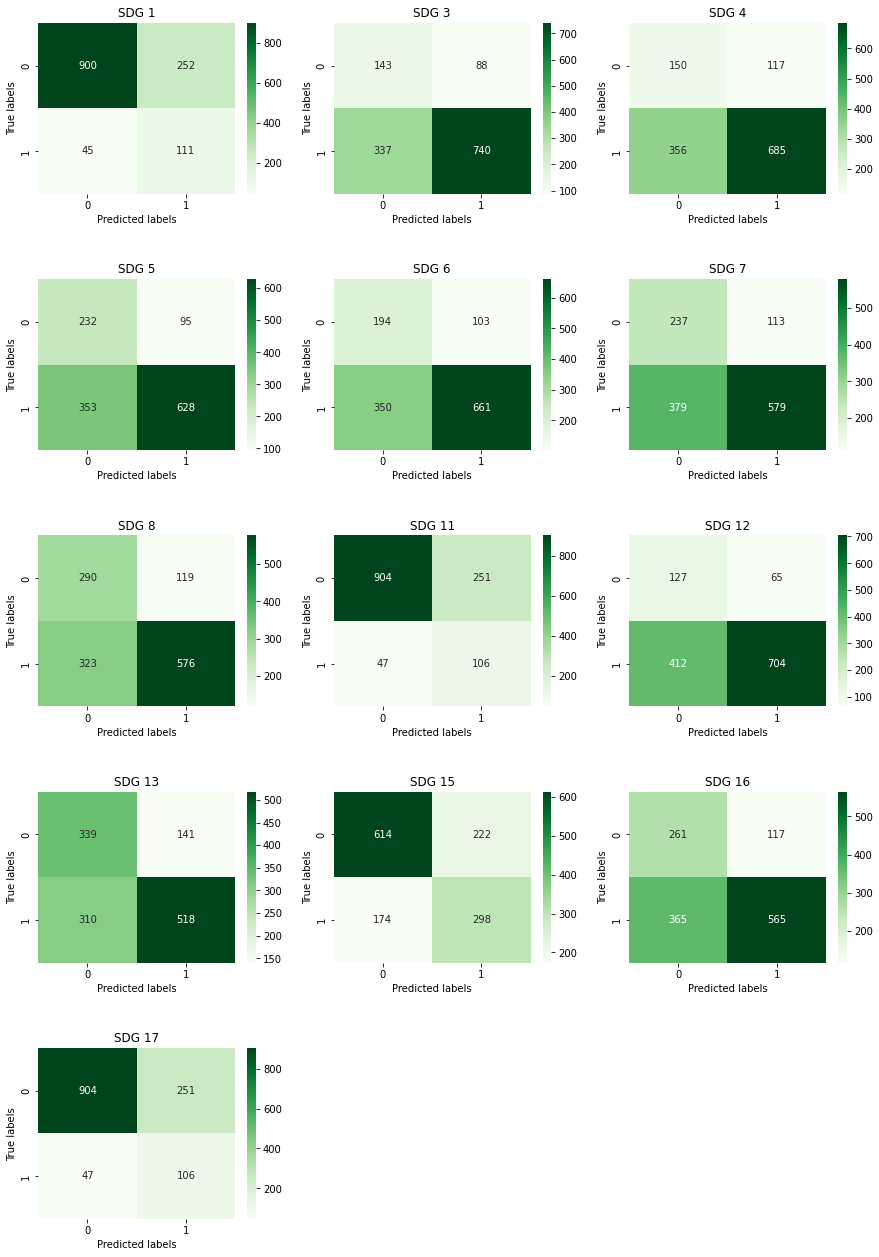

In [16]:
evaluation(grid_svm, outputs_test, Y_test)

### 3.3. Random Forest

In [17]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__n_estimators': [50, 100], # Number of trees in the forest
    'clf__estimator__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_rf.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:  4.0min remaining:   36.5s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  4.1min finished


Best Parameters: {'clf__estimator__max_depth': 10, 'clf__estimator__n_estimators': 50}
Mean cross-validated F1-score of the best estimator: 0.6597715910548521


              precision    recall  f1-score   support

           0       0.74      0.09      0.16       156
           1       0.83      1.00      0.90      1077
           2       0.81      0.99      0.89      1041
           3       0.77      0.97      0.86       981
           4       0.79      0.98      0.87      1011
           5       0.76      0.96      0.85       958
           6       0.71      0.92      0.81       899
           7       0.76      0.08      0.15       153
           8       0.86      0.99      0.92      1116
           9       0.68      0.89      0.77       828
          10       0.62      0.37      0.46       472
          11       0.73      0.95      0.83       930
          12       0.62      0.08      0.15       153

   micro avg       0.77      0.89      0.83      9775
   macro avg       0.75      0.71      0.66      9775
weighted avg       0.77      0.89      0.81      9775
 samples avg       0.77      0.90      0.81      9775



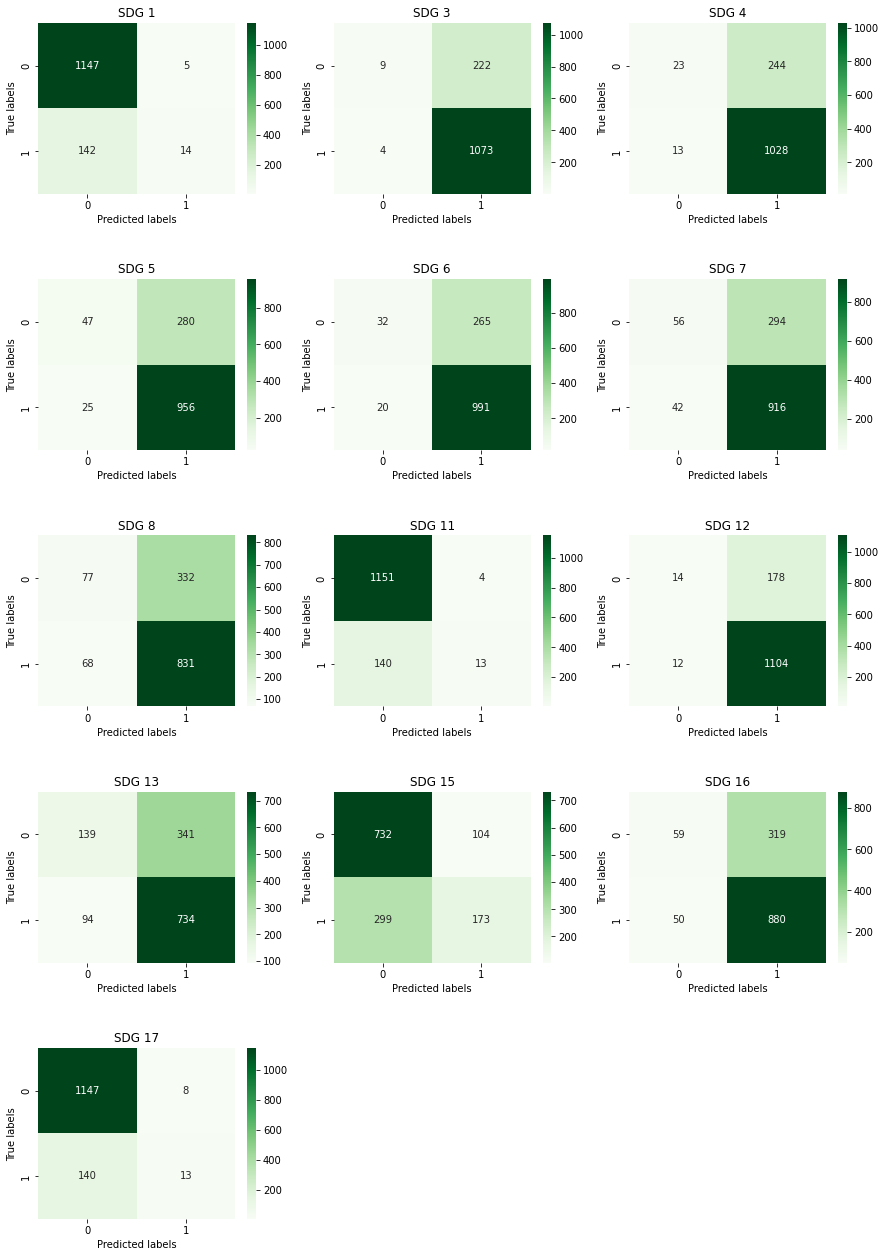

In [18]:
evaluation(grid_rf, outputs_test, Y_test)

## 4. Classification with SMOTE

### 4.1. KNN

In [21]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('clf', KNeighborsClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__n_neighbors': [5, 15, 25, 55] # Number of neighbors
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_knn = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_knn.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_knn.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_knn.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:  4.1min remaining:  2.8min
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  6.2min finished


Best Parameters: {'estimator__clf__n_neighbors': 5}
Mean cross-validated F1-score of the best estimator: 0.2822107540763549


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.664, total=   5.5s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.675, total=  20.6s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.664, total= 2.7min
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.659, total= 3.2min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.660, total=  36.4s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.643, total=  41.2s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_d

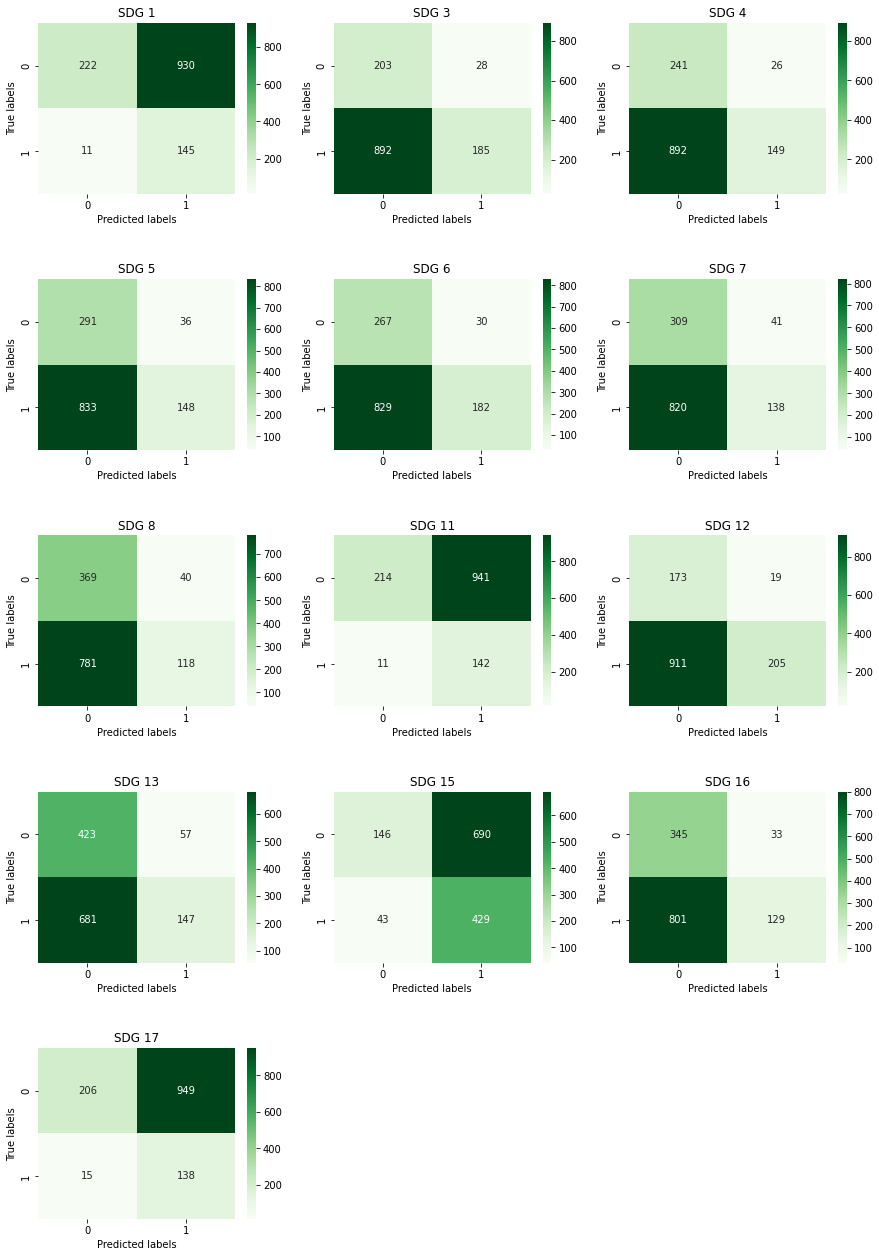

In [22]:
evaluation(grid_knn, outputs_test, Y_test)

### 4.2. Naive Bayes

In [25]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('Normalizing', MinMaxScaler()),
    ('clf', MultinomialNB())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__alpha': [0.01, 0.1, 1] # Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_nb = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_nb.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_nb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_nb.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:   14.3s remaining:   21.4s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   27.6s remaining:    6.9s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   28.3s finished


Best Parameters: {'estimator__clf__alpha': 0.1}
Mean cross-validated F1-score of the best estimator: 0.5953539336554602


              precision    recall  f1-score   support

           0       0.19      0.60      0.29       156
           1       0.86      0.60      0.70      1077
           2       0.84      0.59      0.69      1041
           3       0.80      0.57      0.67       981
           4       0.86      0.58      0.69      1011
           5       0.80      0.54      0.65       958
           6       0.76      0.58      0.65       899
           7       0.18      0.56      0.27       153
           8       0.91      0.56      0.70      1116
           9       0.72      0.54      0.62       828
          10       0.48      0.59      0.53       472
          11       0.76      0.53      0.62       930
          12       0.18      0.56      0.27       153

   micro avg       0.68      0.57      0.62      9775
   macro avg       0.64      0.57      0.57      9775
weighted avg       0.77      0.57      0.64      9775
 samples avg       0.62      0.56      0.54      9775



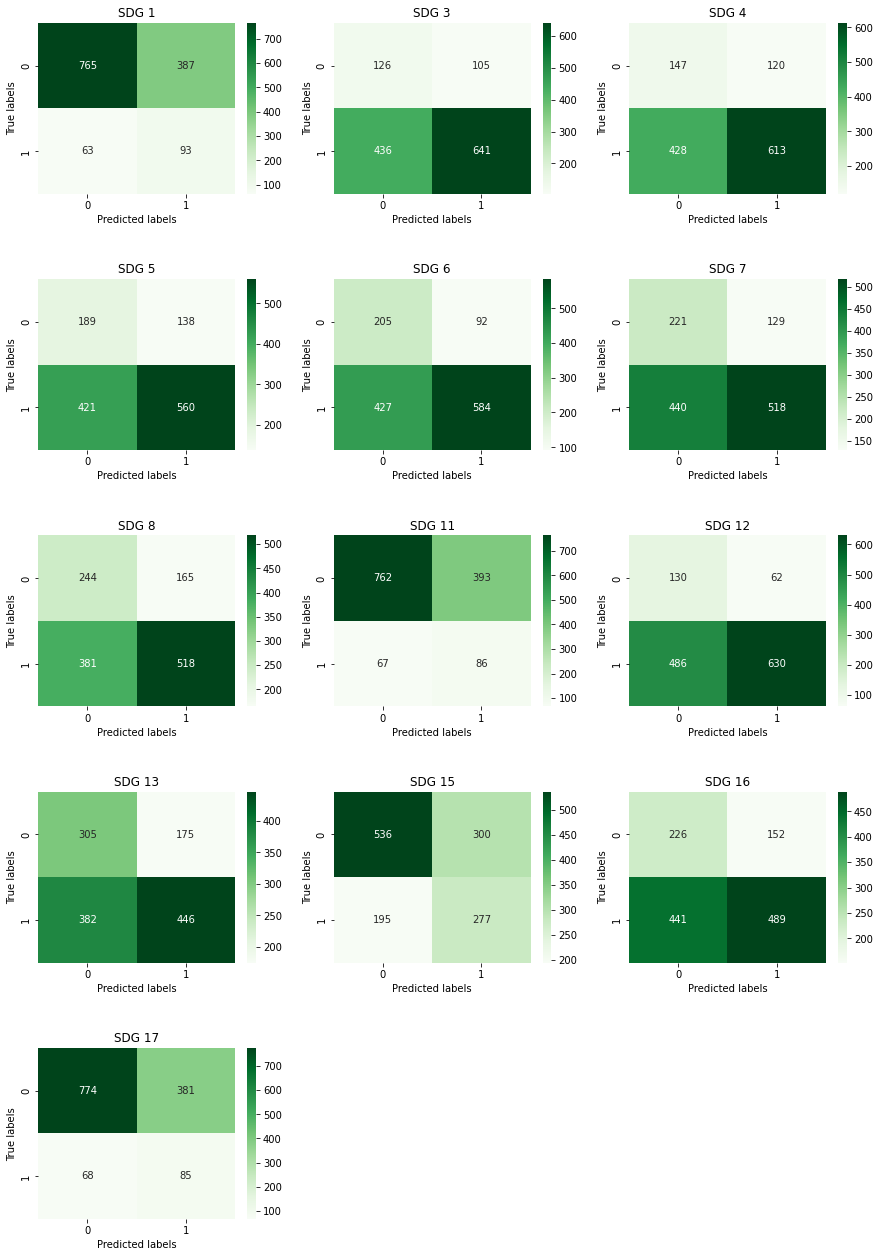

In [26]:
evaluation(grid_nb, outputs_test, Y_test)

### 4.3. XGBoost

In [28]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('clf', XGBClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__n_estimators': [50, 100], # Number of boosting rounds
    'estimator__clf__max_depth': [5, 10] # Maximum tree depth for base learners
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_xgb = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_xgb.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_xgb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_xgb.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.678, total=   5.4s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.674, total=  10.8s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.669, total= 2.7min
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.655, total= 3.2min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.654, total=  35.5s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.643, total=  41.1s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_d

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate

[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.677, total=   5.7s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.675, total=  21.3s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.664, total= 2.4min
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.654, total= 3.2min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.663, total=  35.5s
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.653, total= 1.2min
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Negative values in data passed to MultinomialNB (input X)

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object

[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.653, total= 1.2min
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.642, total=  40.9s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=50, score=0.644, total=  41.4s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=100 
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=100, score=0.648, total= 1.4min
[CV] estimator__clf__n_neighbors=5 ...................................
[CV] ....... estimator__clf__n_neighbors=5, score=0.286, total= 2.1min
[CV] estimator__clf__n_neighbors=25 ..................................
[CV] ...... estimator__clf__n_neighbors=25, score=0.153, total= 2.1min
[CV] estimator__clf__n_neighbors=55 ......

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

[CV] estimator__clf__alpha=0.1 .......................................
[CV] ............. estimator__clf__alpha=0.1, score=nan, total=   0.4s
[CV] estimator__clf__alpha=0.1 .......................................
[CV] ........... estimator__clf__alpha=0.1, score=0.605, total=  13.9s
[CV] estimator__clf__alpha=1 .........................................
[CV] ............. estimator__clf__alpha=1, score=0.606, total=  13.7s
[CV] estimator__clf__max_depth=5, estimator__clf__n_estimators=50 ....
[15:26:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:31:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed: 202.8min remaining: 135.2min


[18:27:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  estimator__clf__max_depth=10, estimator__clf__n_estimators=50, score=0.692, total=149.7min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

[CV] estimator__clf__alpha=0.1 .......................................
[CV] ............. estimator__clf__alpha=0.1, score=nan, total=   0.5s
[CV] estimator__clf__alpha=0.1 .......................................
[CV] ........... estimator__clf__alpha=0.1, score=0.594, total=  14.2s
[CV] estimator__clf__alpha=1 .........................................
[CV] ............. estimator__clf__alpha=1, score=0.582, total=  14.0s
[CV] estimator__clf__max_depth=5, estimator__clf__n_estimators=100 ...
[15:26:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] estimator__clf__alpha=0.01 ......................................
[CV] ............ estimator__clf__alpha=0.01, score=nan, total=   0.4s
[CV] estimator__clf__alpha=0.01 ......................................
[CV] .......... estimator__clf__alpha=0.01, score=0.582, total=  14.1s
[CV] estimator__clf__alpha=1 .........................................
[CV] ............. estimator__clf__alpha=1, score=0.595, total=  13.8s
[CV] estimator__clf__max_depth=5, estimator__clf__n_estimators=100 ...
[15:26:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] estimator__clf__alpha=0.1 .......................................
[CV] ............. estimator__clf__alpha=0.1, score=nan, total=   0.4s
[CV] estimator__clf__alpha=0.01 ......................................
[CV] .......... estimator__clf__alpha=0.01, score=0.583, total=  14.3s
[CV] estimator__clf__alpha=1 .........................................
[CV] ............. estimator__clf__alpha=1, score=0.586, total=  13.7s
[CV] estimator__clf__max_depth=5, estimator__clf__n_estimators=100 ...
[15:26:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] estimator__clf__max_depth=5, estimator__clf__n_estimators=100 ...
[16:20:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:27:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:35:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'l

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[18:48:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:17:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[20:50:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] estimator__clf__max_depth=10, estimator__clf__n_estimators=50 ...
[16:20:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:30:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'l

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[20:55:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

              precision    recall  f1-score   support

           0       0.47      0.27      0.34       156
           1       0.85      0.92      0.88      1077
           2       0.81      0.91      0.86      1041
           3       0.80      0.88      0.84       981
           4       0.81      0.86      0.84      1011
           5       0.77      0.84      0.80       958
           6       0.74      0.80      0.77       899
           7       0.44      0.24      0.31       153
           8       0.88      0.91      0.89      1116
           9       0.71      0.75      0.73       828
          10       0.55      0.46      0.50       472
          11       0.76      0.84      0.80       930
          12       0.40      0.23      0.29       153

   micro avg       0.78      0.81      0.79      9775
   macro avg       0.69      0.68      0.68      9775
weighted avg       0.77      0.81      0.79      9775
 samples avg       0.77      0.81      0.76      9775



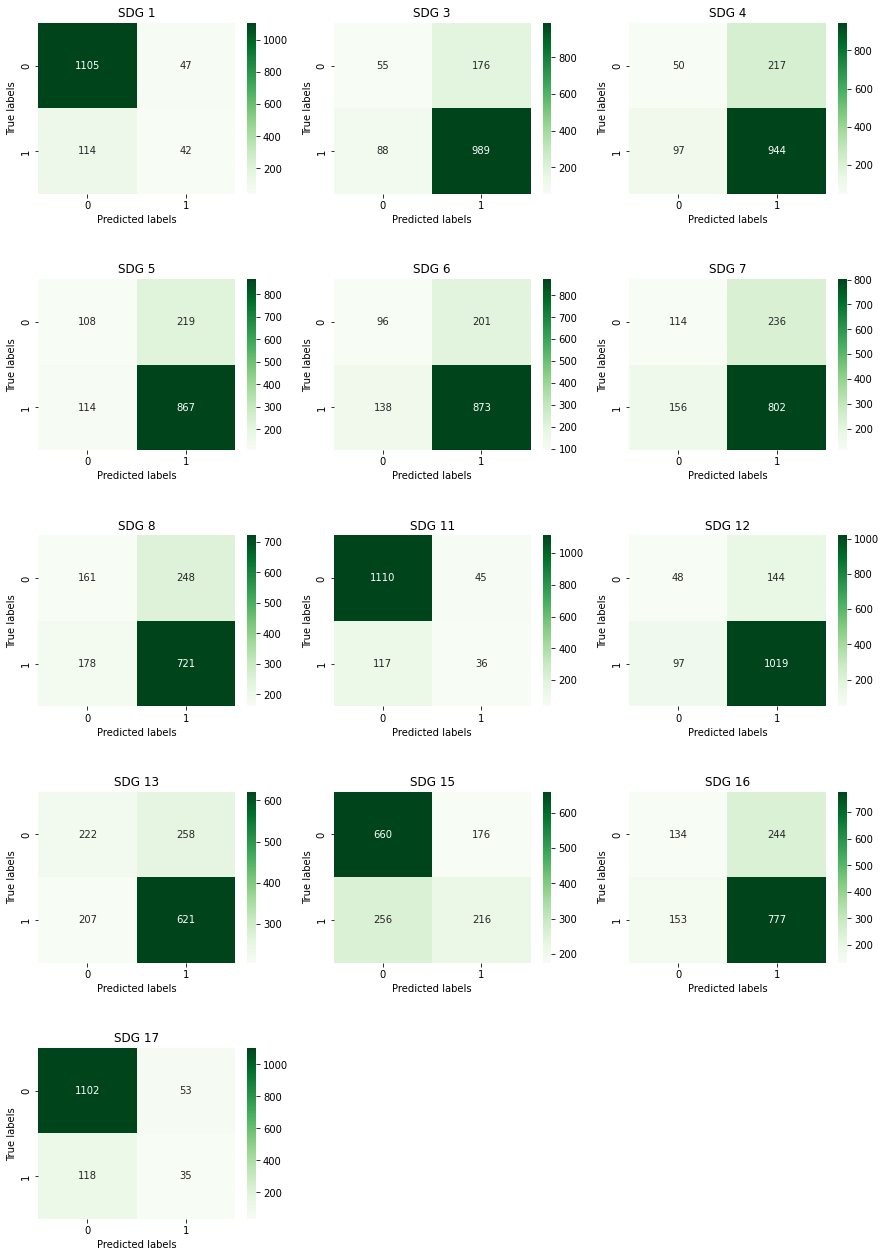

In [29]:
evaluation(grid_xgb, outputs_test, Y_test)